In [94]:
# data analysis
import pandas as pd
import numpy as np
import re

# visualization
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

# machine learning
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix


from sklearn.linear_model import LogisticRegression
from sklearn import svm
from sklearn.svm import SVC, LinearSVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import Perceptron
from sklearn.linear_model import SGDClassifier
from sklearn.tree import DecisionTreeClassifier
#Import scikit-learn metrics module for accuracy calculation
from sklearn import metrics

In [95]:
train=pd.read_csv("train.csv")
train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [96]:
test=pd.read_csv("test.csv")
test.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S


## Explore Data

In [97]:
train.shape

(891, 12)

In [98]:
test.shape

(418, 11)

In [99]:
train.isnull().sum()

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

In [100]:
test.isnull().sum()

PassengerId      0
Pclass           0
Name             0
Sex              0
Age             86
SibSp            0
Parch            0
Ticket           0
Fare             1
Cabin          327
Embarked         0
dtype: int64

## Feature Engineering

In [101]:
full_data = [train, test]

In [102]:
# Gives the length of the name
train['Name_length'] = train['Name'].apply(len)
test['Name_length'] = test['Name'].apply(len)
# Feature that tells whether a passenger had a cabin on the Titanic
train['Has_Cabin'] = train["Cabin"].apply(lambda x: 0 if type(x) == float else 1)
test['Has_Cabin'] = test["Cabin"].apply(lambda x: 0 if type(x) == float else 1)

In [103]:
# Create new feature FamilySize as a combination of SibSp and Parch
for dataset in full_data:
    dataset['FamilySize'] = dataset['SibSp'] + dataset['Parch'] + 1
# Create new feature IsAlone from FamilySize
for dataset in full_data:
    dataset['IsAlone'] = 0
    dataset.loc[dataset['FamilySize'] == 1, 'IsAlone'] = 1
# Remove all NULLS in the Embarked column
for dataset in full_data:
    dataset['Embarked'] = dataset['Embarked'].fillna('S')
# Remove all NULLS in the Fare column and create a new feature CategoricalFare
for dataset in full_data:
    dataset['Fare'] = dataset['Fare'].fillna(train['Fare'].median())
train['CategoricalFare'] = pd.qcut(train['Fare'], 4)
# Create a New feature CategoricalAge
for dataset in full_data:
    age_avg = dataset['Age'].mean()
    age_std = dataset['Age'].std()
    age_null_count = dataset['Age'].isnull().sum()
    age_null_random_list = np.random.randint(age_avg - age_std, age_avg + age_std, size=age_null_count)
    dataset['Age'][np.isnan(dataset['Age'])] = age_null_random_list
    dataset['Age'] = dataset['Age'].astype(int)
train['CategoricalAge'] = pd.cut(train['Age'], 5)
# Define function to extract titles from passenger names
def get_title(name):
    title_search = re.search(' ([A-Za-z]+)\.', name)
    # If the title exists, extract and return it.
    if title_search:
        return title_search.group(1)
    return ""
# Create a new feature Title, containing the titles of passenger names
for dataset in full_data:
    dataset['Title'] = dataset['Name'].apply(get_title)
# Group all non-common titles into one single grouping "Rare"
for dataset in full_data:
    dataset['Title'] = dataset['Title'].replace(['Lady', 'Countess','Capt', 'Col','Don', 'Dr', 'Major', 'Rev', 'Sir', 'Jonkheer', 'Dona'], 'Rare')

    dataset['Title'] = dataset['Title'].replace('Mlle', 'Miss')
    dataset['Title'] = dataset['Title'].replace('Ms', 'Miss')
    dataset['Title'] = dataset['Title'].replace('Mme', 'Mrs')

/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


## data processing

In [104]:
for dataset in full_data:
    # Mapping Sex
    dataset['Sex'] = dataset['Sex'].map( {'female': 0, 'male': 1} ).astype(int)
    
    # Mapping titles
    title_mapping = {"Mr": 1, "Miss": 2, "Mrs": 3, "Master": 4, "Rare": 5}
    dataset['Title'] = dataset['Title'].map(title_mapping)
    dataset['Title'] = dataset['Title'].fillna(0)
    
    # Mapping Embarked
    dataset['Embarked'] = dataset['Embarked'].map( {'S': 0, 'C': 1, 'Q': 2} ).astype(int)
    
    # Mapping Fare
    dataset.loc[ dataset['Fare'] <= 7.91, 'Fare'] 						        = 0
    dataset.loc[(dataset['Fare'] > 7.91) & (dataset['Fare'] <= 14.454), 'Fare'] = 1
    dataset.loc[(dataset['Fare'] > 14.454) & (dataset['Fare'] <= 31), 'Fare']   = 2
    dataset.loc[ dataset['Fare'] > 31, 'Fare'] 							        = 3
    dataset['Fare'] = dataset['Fare'].astype(int)
        
    # Mapping Age
    dataset.loc[ dataset['Age'] <= 16, 'Age'] 					       = 0
    dataset.loc[(dataset['Age'] > 16) & (dataset['Age'] <= 32), 'Age'] = 1
    dataset.loc[(dataset['Age'] > 32) & (dataset['Age'] <= 48), 'Age'] = 2
    dataset.loc[(dataset['Age'] > 48) & (dataset['Age'] <= 64), 'Age'] = 3
    dataset.loc[ dataset['Age'] > 64, 'Age'] = 4 ;

## Feature selection

In [105]:
train.head(2)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Name_length,Has_Cabin,FamilySize,IsAlone,CategoricalFare,CategoricalAge,Title
0,1,0,3,"Braund, Mr. Owen Harris",1,1,1,0,A/5 21171,0,NaN,0,23,0,2,0,"(-0.001, 7.91]","(16.0, 32.0]",1
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",0,2,1,0,PC 17599,3,C85,1,51,1,2,0,"(31.0, 512.329]","(32.0, 48.0]",3


In [106]:
test.head(2)

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Name_length,Has_Cabin,FamilySize,IsAlone,Title
0,892,3,"Kelly, Mr. James",1,2,0,0,330911,0,NaN,2,16,0,1,1,1
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",0,2,1,0,363272,0,NaN,0,32,0,2,0,3


In [107]:
# Feature selection
drop_elements = ['PassengerId', 'Name', 'Ticket', 'Cabin', 'SibSp']
train = train.drop(drop_elements, axis = 1)
train = train.drop(['CategoricalAge', 'CategoricalFare'], axis = 1)
test  = test.drop(drop_elements, axis = 1)

In [108]:
train.head(2)

,Survived,Pclass,Sex,Age,Parch,Fare,Embarked,Name_length,Has_Cabin,FamilySize,IsAlone,Title
0,0,3,1,1,0,0,0,23,0,2,0,1
1,1,1,0,2,0,3,1,51,1,2,0,3


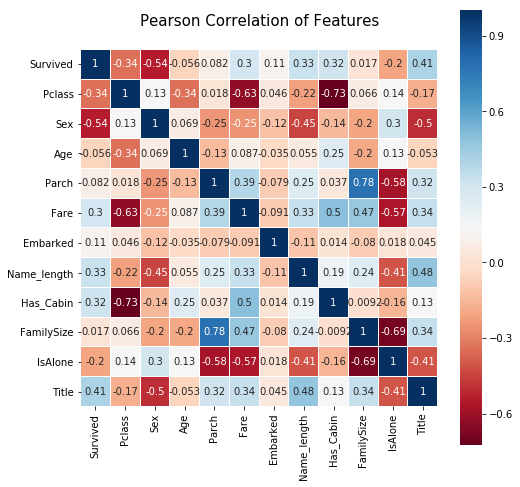

In [109]:
colormap = plt.cm.RdBu
plt.figure(figsize=(8,8))
plt.title('Pearson Correlation of Features', y=1.05, size=15)
sns.heatmap(train.astype(float).corr(),linewidths=0.1,vmax=1.0, 
            square=True, cmap=colormap, linecolor='white', annot=True)

# Model Training

## Split train test data

In [110]:
features = ['Pclass','Sex','Age','Parch','Fare','Embarked',
            'Name_length','Has_Cabin','FamilySize','IsAlone','Title']
target = 'Survived'

In [111]:
X_train, X_test, Y_train, Y_test = train_test_split(train[features], 
                                                    train[target], 
                                                    test_size = 0.3)

In [112]:
print(X_train.shape)
print(Y_train.shape)
print(X_test.shape)
print(Y_test.shape)

(623, 11)
(623,)
(268, 11)
(268,)


# train a model

In [114]:
rf = RandomForestClassifier()
rf.fit(X_train, Y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [115]:
Y_pred = rf.predict(X_test)

In [116]:
# Accuracy
accuracy_score(Y_test, Y_pred)

0.7798507462686567

In [117]:
# Confusion Matrix
confusion_matrix(Y_test, Y_pred)

array([[136,  22],
       [ 37,  73]])

In [155]:
# Recall
recall=136/(136+37)
recall

0.7861271676300579

In [156]:
# Precision
precision=136/(136+22)
precision

0.8607594936708861

In [158]:
# Sensitivity
sensitivity=recall
sensitivity

0.7861271676300579

In [122]:
#KNN 

In [123]:
#KNN Model
knn = KNeighborsClassifier(n_neighbors=3)
knn.fit(X_train, Y_train)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=3, p=2,
           weights='uniform')

In [124]:
Y_pred = knn.predict(X_test)
accuracy_score(Y_test, Y_pred)

0.7350746268656716

In [125]:
#which K Performs the best
k_range = range(1,26)
scores_list = []
for k in k_range:
    knn = KNeighborsClassifier(n_neighbors=k)
    knn.fit(X_train, Y_train)
    y_pred = knn.predict(X_test)
    scores_list.append(metrics.accuracy_score(Y_test, Y_pred))

Text(0,0.5,'Testing Accuracy')

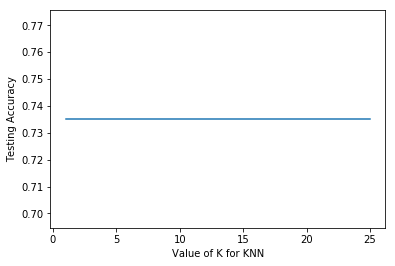

In [126]:
plt.plot(k_range, scores_list)
plt.xlabel('Value of K for KNN')
plt.ylabel('Testing Accuracy')

In [128]:
#Cross validation

In [131]:
#K-fold cross validation
from sklearn.model_selection import KFold

In [132]:
scores = []
best_RF = RandomForestClassifier()

cv = KFold(n_splits=10, random_state=42, shuffle=False)

for train_index, test_index in cv.split(train):
    
    X_train1 = train.iloc[train_index][features]
    X_test1 = train.iloc[test_index][features]
    y_train1 = train.iloc[train_index][target]
    y_test1 = train.iloc[test_index][target]
    
    best_RF.fit(X_train1, y_train1)
    
    scores.append(best_RF.score(X_test1, y_test1))

In [133]:
scores

[0.7555555555555555,
 0.8426966292134831,
 0.7752808988764045,
 0.7752808988764045,
 0.797752808988764,
 0.8314606741573034,
 0.7528089887640449,
 0.7528089887640449,
 0.8089887640449438,
 0.8426966292134831]

In [134]:
np.mean(scores)

0.7935330836454432

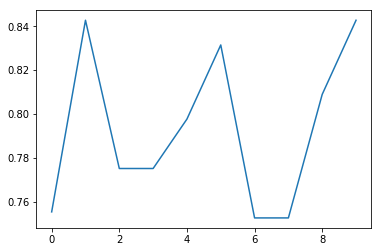

In [135]:
plt.plot(range(len(scores)), scores)

In [137]:
#K-fold cv on knn
scores = []
best_KNN = KNeighborsClassifier(n_neighbors=3)

cv = KFold(n_splits=10, random_state=42, shuffle=False)

for train_index, test_index in cv.split(train):
    
    X_train2 = train.iloc[train_index][features]
    X_test2 = train.iloc[test_index][features]
    y_train2 = train.iloc[train_index][target]
    y_test2 = train.iloc[test_index][target]
    
    best_KNN.fit(X_train2, y_train2)
    
    scores.append(best_KNN.score(X_test2, y_test2))

In [138]:
scores

[0.6666666666666666,
 0.8089887640449438,
 0.7752808988764045,
 0.7640449438202247,
 0.7865168539325843,
 0.7752808988764045,
 0.7528089887640449,
 0.7528089887640449,
 0.8314606741573034,
 0.8089887640449438]

In [139]:
np.mean(scores)

0.7722846441947565

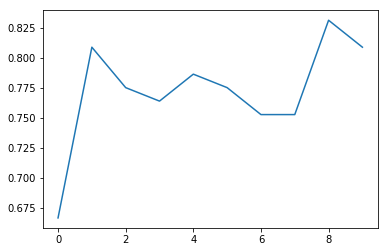

In [140]:
plt.plot(range(len(scores)), scores)

# Model Tuning: Grid Search

In [141]:
from sklearn.ensemble import RandomForestRegressor

rf = RandomForestRegressor(random_state = 42)

from pprint import pprint
# Look at parameters used by our current forest
print('Parameters currently in use:\n')
pprint(rf.get_params())

Parameters currently in use:

{'bootstrap': True,
 'criterion': 'mse',
 'max_depth': None,
 'max_features': 'auto',
 'max_leaf_nodes': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 10,
 'n_jobs': 1,
 'oob_score': False,
 'random_state': 42,
 'verbose': 0,
 'warm_start': False}


* n_estimators = number of trees in the foreset
* max_features = max number of features considered for splitting a node
* max_depth = max number of levels in each decision tree
* min_samples_split = min number of data points placed in a node before the node is split
* min_samples_leaf = min number of data points allowed in a leaf node
* bootstrap = method for sampling data points (with or without replacement)

In [142]:
from sklearn.model_selection import RandomizedSearchCV

# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 100, stop = 300, num = 3)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 30, num = 3)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2]
# Method of selecting samples for training each tree
bootstrap = [True, False]
# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}
pprint(random_grid)

{'bootstrap': [True, False],
 'max_depth': [10, 20, 30, None],
 'max_features': ['auto', 'sqrt'],
 'min_samples_leaf': [1, 2],
 'min_samples_split': [5, 10],
 'n_estimators': [100, 200, 300]}


In [146]:
# Use the random grid to search for best hyperparameters
# First create the base model to tune
rf = RandomForestClassifier()
# Random search of parameters, using 3 fold cross validation, 
# search across 100 different combinations, and use all available cores
rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, n_iter = 100, cv = 3, verbose=2, random_state=42, n_jobs = -1)
# Fit the random search model
rf_random.fit(X_train, Y_train)

Fitting 3 folds for each of 100 candidates, totalling 300 fits
[CV] n_estimators=100, min_samples_split=10, min_samples_leaf=2, max_features=sqrt, max_depth=20, bootstrap=True 
[CV] n_estimators=100, min_samples_split=10, min_samples_leaf=2, max_features=sqrt, max_depth=20, bootstrap=True 
[CV] n_estimators=100, min_samples_split=10, min_samples_leaf=2, max_features=sqrt, max_depth=20, bootstrap=True 
[CV] n_estimators=200, min_samples_split=10, min_samples_leaf=1, max_features=sqrt, max_depth=20, bootstrap=False 
[CV]  n_estimators=100, min_samples_split=10, min_samples_leaf=2, max_features=sqrt, max_depth=20, bootstrap=True, total=   0.3s
[CV]  n_estimators=100, min_samples_split=10, min_samples_leaf=2, max_features=sqrt, max_depth=20, bootstrap=True, total=   0.3s
[CV]  n_estimators=100, min_samples_split=10, min_samples_leaf=2, max_features=sqrt, max_depth=20, bootstrap=True, total=   0.3s
[CV] n_estimators=200, min_samples_split=10, min_samples_leaf=1, max_features=sqrt, max_depth

[CV] n_estimators=200, min_samples_split=10, min_samples_leaf=1, max_features=sqrt, max_depth=10, bootstrap=False 
[CV]  n_estimators=100, min_samples_split=5, min_samples_leaf=2, max_features=auto, max_depth=None, bootstrap=True, total=   0.6s
[CV] n_estimators=100, min_samples_split=5, min_samples_leaf=2, max_features=sqrt, max_depth=30, bootstrap=True 


[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:    6.2s


[CV]  n_estimators=200, min_samples_split=10, min_samples_leaf=1, max_features=sqrt, max_depth=10, bootstrap=False, total=   1.0s
[CV] n_estimators=100, min_samples_split=5, min_samples_leaf=2, max_features=sqrt, max_depth=30, bootstrap=True 
[CV]  n_estimators=100, min_samples_split=5, min_samples_leaf=2, max_features=sqrt, max_depth=30, bootstrap=True, total=   0.4s
[CV] n_estimators=100, min_samples_split=5, min_samples_leaf=2, max_features=sqrt, max_depth=30, bootstrap=True 
[CV]  n_estimators=200, min_samples_split=10, min_samples_leaf=1, max_features=sqrt, max_depth=10, bootstrap=False, total=   1.0s
[CV] n_estimators=300, min_samples_split=10, min_samples_leaf=1, max_features=sqrt, max_depth=30, bootstrap=True 
[CV]  n_estimators=200, min_samples_split=10, min_samples_leaf=1, max_features=sqrt, max_depth=10, bootstrap=False, total=   1.0s
[CV] n_estimators=300, min_samples_split=10, min_samples_leaf=1, max_features=sqrt, max_depth=30, bootstrap=True 
[CV]  n_estimators=100, min_

[CV]  n_estimators=200, min_samples_split=10, min_samples_leaf=2, max_features=sqrt, max_depth=10, bootstrap=False, total=   0.5s
[CV] n_estimators=300, min_samples_split=5, min_samples_leaf=1, max_features=auto, max_depth=10, bootstrap=False 
[CV]  n_estimators=200, min_samples_split=10, min_samples_leaf=2, max_features=sqrt, max_depth=10, bootstrap=False, total=   0.5s
[CV] n_estimators=200, min_samples_split=5, min_samples_leaf=2, max_features=sqrt, max_depth=30, bootstrap=True 
[CV]  n_estimators=300, min_samples_split=5, min_samples_leaf=1, max_features=auto, max_depth=10, bootstrap=False, total=   0.8s
[CV] n_estimators=200, min_samples_split=5, min_samples_leaf=2, max_features=sqrt, max_depth=30, bootstrap=True 
[CV]  n_estimators=300, min_samples_split=5, min_samples_leaf=1, max_features=auto, max_depth=10, bootstrap=False, total=   0.8s
[CV] n_estimators=200, min_samples_split=5, min_samples_leaf=2, max_features=sqrt, max_depth=30, bootstrap=True 
[CV]  n_estimators=200, min_s

[CV]  n_estimators=100, min_samples_split=5, min_samples_leaf=2, max_features=sqrt, max_depth=None, bootstrap=True, total=   0.6s
[CV] n_estimators=300, min_samples_split=10, min_samples_leaf=1, max_features=auto, max_depth=10, bootstrap=True 
[CV]  n_estimators=300, min_samples_split=5, min_samples_leaf=1, max_features=auto, max_depth=None, bootstrap=False, total=   1.3s
[CV] n_estimators=300, min_samples_split=10, min_samples_leaf=1, max_features=auto, max_depth=10, bootstrap=True 
[CV]  n_estimators=300, min_samples_split=5, min_samples_leaf=1, max_features=auto, max_depth=None, bootstrap=False, total=   1.2s
[CV] n_estimators=300, min_samples_split=10, min_samples_leaf=1, max_features=auto, max_depth=10, bootstrap=True 
[CV]  n_estimators=300, min_samples_split=10, min_samples_leaf=1, max_features=auto, max_depth=10, bootstrap=True, total=   0.9s
[CV] n_estimators=200, min_samples_split=5, min_samples_leaf=1, max_features=sqrt, max_depth=20, bootstrap=False 
[CV]  n_estimators=300,

[CV]  n_estimators=300, min_samples_split=5, min_samples_leaf=1, max_features=sqrt, max_depth=None, bootstrap=False, total=   0.7s
[CV] n_estimators=300, min_samples_split=10, min_samples_leaf=1, max_features=auto, max_depth=10, bootstrap=False 
[CV]  n_estimators=300, min_samples_split=5, min_samples_leaf=1, max_features=sqrt, max_depth=None, bootstrap=False, total=   0.7s
[CV] n_estimators=300, min_samples_split=10, min_samples_leaf=1, max_features=auto, max_depth=10, bootstrap=False 
[CV]  n_estimators=300, min_samples_split=5, min_samples_leaf=1, max_features=sqrt, max_depth=None, bootstrap=False, total=   0.7s
[CV] n_estimators=200, min_samples_split=5, min_samples_leaf=2, max_features=auto, max_depth=30, bootstrap=True 
[CV]  n_estimators=300, min_samples_split=10, min_samples_leaf=1, max_features=auto, max_depth=10, bootstrap=False, total=   0.8s
[CV] n_estimators=200, min_samples_split=5, min_samples_leaf=2, max_features=auto, max_depth=30, bootstrap=True 
[CV]  n_estimators=20

[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:   24.9s


[CV]  n_estimators=100, min_samples_split=10, min_samples_leaf=1, max_features=auto, max_depth=30, bootstrap=True, total=   0.2s
[CV] n_estimators=100, min_samples_split=10, min_samples_leaf=1, max_features=auto, max_depth=30, bootstrap=True 
[CV]  n_estimators=100, min_samples_split=10, min_samples_leaf=1, max_features=auto, max_depth=30, bootstrap=True, total=   0.2s
[CV]  n_estimators=300, min_samples_split=5, min_samples_leaf=2, max_features=auto, max_depth=30, bootstrap=True, total=   0.8s
[CV] n_estimators=100, min_samples_split=10, min_samples_leaf=1, max_features=auto, max_depth=30, bootstrap=True 
[CV] n_estimators=200, min_samples_split=5, min_samples_leaf=2, max_features=sqrt, max_depth=30, bootstrap=False 
[CV]  n_estimators=300, min_samples_split=5, min_samples_leaf=2, max_features=auto, max_depth=30, bootstrap=True, total=   0.8s
[CV] n_estimators=200, min_samples_split=5, min_samples_leaf=2, max_features=sqrt, max_depth=30, bootstrap=False 
[CV]  n_estimators=300, min_sa

[CV]  n_estimators=200, min_samples_split=5, min_samples_leaf=1, max_features=auto, max_depth=10, bootstrap=False, total=   0.5s
[CV] n_estimators=300, min_samples_split=5, min_samples_leaf=1, max_features=auto, max_depth=20, bootstrap=True 
[CV]  n_estimators=200, min_samples_split=5, min_samples_leaf=1, max_features=auto, max_depth=10, bootstrap=False, total=   0.5s
[CV] n_estimators=100, min_samples_split=10, min_samples_leaf=1, max_features=auto, max_depth=20, bootstrap=False 
[CV]  n_estimators=100, min_samples_split=10, min_samples_leaf=1, max_features=auto, max_depth=20, bootstrap=False, total=   0.2s
[CV] n_estimators=100, min_samples_split=10, min_samples_leaf=1, max_features=auto, max_depth=20, bootstrap=False 
[CV]  n_estimators=300, min_samples_split=5, min_samples_leaf=1, max_features=auto, max_depth=20, bootstrap=True, total=   0.8s
[CV] n_estimators=100, min_samples_split=10, min_samples_leaf=1, max_features=auto, max_depth=20, bootstrap=False 
[CV]  n_estimators=300, mi

[CV]  n_estimators=100, min_samples_split=5, min_samples_leaf=1, max_features=sqrt, max_depth=None, bootstrap=False, total=   0.3s
[CV] n_estimators=100, min_samples_split=10, min_samples_leaf=1, max_features=sqrt, max_depth=None, bootstrap=False 
[CV]  n_estimators=100, min_samples_split=10, min_samples_leaf=1, max_features=sqrt, max_depth=None, bootstrap=False, total=   0.2s
[CV] n_estimators=100, min_samples_split=10, min_samples_leaf=1, max_features=sqrt, max_depth=None, bootstrap=False 
[CV]  n_estimators=200, min_samples_split=10, min_samples_leaf=2, max_features=sqrt, max_depth=10, bootstrap=True, total=   0.5s
[CV] n_estimators=100, min_samples_split=10, min_samples_leaf=1, max_features=sqrt, max_depth=None, bootstrap=False 
[CV]  n_estimators=200, min_samples_split=10, min_samples_leaf=2, max_features=sqrt, max_depth=10, bootstrap=True, total=   0.5s
[CV] n_estimators=100, min_samples_split=10, min_samples_leaf=2, max_features=sqrt, max_depth=10, bootstrap=False 
[CV]  n_estim

[CV]  n_estimators=300, min_samples_split=5, min_samples_leaf=2, max_features=auto, max_depth=20, bootstrap=True, total=   0.8s
[CV] n_estimators=200, min_samples_split=10, min_samples_leaf=1, max_features=auto, max_depth=20, bootstrap=False 
[CV]  n_estimators=300, min_samples_split=5, min_samples_leaf=2, max_features=auto, max_depth=20, bootstrap=True, total=   0.7s
[CV] n_estimators=200, min_samples_split=10, min_samples_leaf=1, max_features=auto, max_depth=20, bootstrap=False 
[CV]  n_estimators=200, min_samples_split=10, min_samples_leaf=1, max_features=auto, max_depth=20, bootstrap=False, total=   0.5s
[CV] n_estimators=100, min_samples_split=5, min_samples_leaf=2, max_features=sqrt, max_depth=20, bootstrap=False 
[CV]  n_estimators=300, min_samples_split=5, min_samples_leaf=2, max_features=auto, max_depth=20, bootstrap=True, total=   0.8s
[CV] n_estimators=100, min_samples_split=5, min_samples_leaf=2, max_features=sqrt, max_depth=20, bootstrap=False 
[CV]  n_estimators=100, min_

[CV]  n_estimators=200, min_samples_split=10, min_samples_leaf=2, max_features=sqrt, max_depth=30, bootstrap=True, total=   0.5s
[CV] n_estimators=200, min_samples_split=10, min_samples_leaf=2, max_features=sqrt, max_depth=30, bootstrap=True 
[CV]  n_estimators=300, min_samples_split=5, min_samples_leaf=1, max_features=auto, max_depth=30, bootstrap=False, total=   0.8s
[CV] n_estimators=200, min_samples_split=5, min_samples_leaf=2, max_features=sqrt, max_depth=None, bootstrap=False 
[CV]  n_estimators=300, min_samples_split=5, min_samples_leaf=1, max_features=auto, max_depth=30, bootstrap=False, total=   0.8s
[CV] n_estimators=200, min_samples_split=5, min_samples_leaf=2, max_features=sqrt, max_depth=None, bootstrap=False 
[CV]  n_estimators=200, min_samples_split=10, min_samples_leaf=2, max_features=sqrt, max_depth=30, bootstrap=True, total=   0.5s
[CV] n_estimators=200, min_samples_split=5, min_samples_leaf=2, max_features=sqrt, max_depth=None, bootstrap=False 
[CV]  n_estimators=200

[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:   46.8s finished


RandomizedSearchCV(cv=3, error_score='raise',
          estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False),
          fit_params=None, iid=True, n_iter=100, n_jobs=-1,
          param_distributions={'n_estimators': [100, 200, 300], 'max_features': ['auto', 'sqrt'], 'max_depth': [10, 20, 30, None], 'min_samples_split': [5, 10], 'min_samples_leaf': [1, 2], 'bootstrap': [True, False]},
          pre_dispatch='2*n_jobs', random_state=42, refit=True,
          return_train_score='warn', scoring=None, verbose=2)

In [147]:
rf_random.best_params_

{'n_estimators': 100,
 'min_samples_split': 10,
 'min_samples_leaf': 1,
 'max_features': 'auto',
 'max_depth': None,
 'bootstrap': True}

In [148]:
best_rf = rf_random.best_estimator_

In [149]:
Y_pred = best_rf.predict(X_test)

In [150]:
accuracy_score(Y_test, Y_pred)

0.8246268656716418

In [151]:
confusion_matrix(Y_test, Y_pred)

array([[140,  18],
       [ 29,  81]])